[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/Priesemann-Group/covid19_inference/blob/master/scripts/interactive/example_one_bundesland.ipynb)

# Parametersensivitätsanalyse für lambda_0
## Deutschland vom 10.03.2020 bis 10.06.2020

Initial definieren wir wie viele Threads wir bei dem MCMC-Sampling gleichzeitig rechnen lassen wollen (`%env OMP_NUM_Thread`). Zudem soll das `covid19_inference`-Modul installiert werden. Ferner stellen wir mit `%load_ext autoreload` und `%autoreload 2` sicher, dass automatisch die Module vor der Ausführung des Codes nachgeladen werden. Das kann insbesondere dann hilfreich sein, wenn wir Änderungen durchführen, den Kernel aber nicht neustarten wollen. Zusätzlich wird das `pytensor`-Modul geladen sowie das `pymc`. Vor allem `pymc` spielt in der Bayes'schen Inferenz eine wichtige Rolle.

In [ ]:
# use 1 thread per chain
%env OMP_NUM_THREADS=1

!pip install covid19_inference
%load_ext autoreload
%autoreload 2
import pytensor
import pymc as pm

env: OMP_NUM_THREADS=1
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload




# Beispiel für Deutschland
Hier verwenden wir JHU-Daten.


An dieser Stelle werden zunächst die Voraussetzungen geladen. Diese sollten zuvor installiert worden sein, damit wir diese auch importieren können.


In [ ]:
import datetime
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pytensor.tensor as at
import pymc as pm
import timeit

Nun importieren wir das installierte Modul `covid19_inference`

In [ ]:

try:
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append("../../")
    import covid19_inference as cov19


## Datengenerierung

Als nächstes wir das Datenset geladen bzw. heruntergeladen. Es gibt insgesamt viele möglichen Download-Ressourcen, jedoch verwenden wir in diesem Fall den von der John Hopkins Universität.
[Github-Repository Link für die csv-Datei](https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv)


In [ ]:
jhu = (
    cov19.data_retrieval.JHU()
)
jhu.download_all_available_data(force_download=False)

Wir können auf die Daten nun mithilfe von jhu.daten zugreifen.

Wir erstellen erstmal einen intialen Zeitraum vom 10.03.2020 bis zum 16.04.2020


In [ ]:
bd = datetime.datetime(2020, 3, 10)  # For the date filter
ed = datetime.datetime(2020, 6, 10)

Hier werden die totalen Fallzahlen bzw. neu gemeldeten Fallzahlen aus dem Datensatz gefiltert. Wir geben dabei den Üebrgabeparameter `country="Germany"` an, da wir die Datenanalyse für Deutschland durchführen wollen.

In [ ]:
total_cases_obs = jhu.get_total(
    country="Germany", data_begin=bd, data_end=ed
)
new_cases_obs = jhu.get_new(
    country="Germany", data_begin=bd, data_end=ed
)



## Modellerstellung
Um das Modell zu erstellen, werden zunächst einige Parameter gesetzt.


*   diff_data_sim
*   num_days_forecast




In [ ]:
diff_data_sim = 16
num_days_forecast = 10

*   `prior_date_mild_dist_begin`: Wir setzen einen Zeitpunkt fest für den Beginn der ersten politischen Maßnahme
*   `prior_date_strong_dist_begin`: Wir setzen einen Zeitpunkt für die nächste politische Maßnahme
*   `prior_date_contact_ban_begin`: Wir setzen einen Zeitpunkt für das Einsetzen der ersten Kontaktsperre

In [ ]:
# We set the priors for the changepoints here
prior_date_mild_dist_begin = datetime.datetime(2020, 3, 9)
prior_date_strong_dist_begin = datetime.datetime(2020, 3, 16)
prior_date_contact_ban_begin = datetime.datetime(2020, 3, 23)


*   `change_points`: Ein Dictionary, das jeweils Einträge für die 3 politischen Maßnahmen enthält. Dazu werden jeweils Parameter gesetzt, wie der Prior für die Ansteckungsrate λ
*   pr_mean_date_transient
*   pr_sigma_date_transient
*   pr_median_lambda
*   pr_sigma_lambda

In [ ]:
change_points = [
    dict(
        pr_mean_date_transient=prior_date_mild_dist_begin,
        pr_sigma_date_transient=3,
        pr_median_lambda=0.2,
        pr_sigma_lambda=1,

    ),
    dict(
        pr_mean_date_transient=prior_date_strong_dist_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_contact_ban_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8 / 2,
        pr_sigma_lambda=1,
    ),
]

*  `params_model:` Ein Dictionary, das verschiedene Parameter enthält. Zum Einen die neu gemeldeten Fallzahlen, aber auch die Länge der Vorhersage sowie die Anzahl der Population
*   `pr_delay`: Hier wollen wir den Prior setzen für den Parameter der Meldeverzögerung


In [ ]:
params_model = dict(
    new_cases_obs=new_cases_obs[:],
    data_begin=bd,
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population=4e6,
)
# Median of the prior for the delay in case reporting, we assume 10 days
pr_delay = 10

Mit dem zuvor definieren params_model wollen wir nun ein sogenanntes Cov19-Modell erstellen. Dazu initialiseren wir dieses Objekt mit einem Array für die zeitabhängige Infektionsrate λ (`lambda_t_log`). Ferner setzen wir die Priori-Verteilung der Genesungsrate μ. Zudem wird auch `I_begin` durch einen Prior bestimmt.
Um das SIR-Modell zu erstellen benötigt es dann die zeitabhängige Infektionsrate (`lambda_t_log`), die Genesungsrate μ und `I_begin`. Wir speichern das SIR-Modell in der Variablen `new_cases`. Diese wird dann verändert mit der `delay`-Funktion, in der wir die Meldungen um einen lognormal Verzögerungswert verändern. Als letztes wird noch der Wochenendeffekt betrachtet. Hier wird die Funktion `week_modulation` auf das SIR-Modell angewandt.
Zuletzt wird noch die `student_t_likelihoo`d-Funktion auf das SIR-Modell angewandt.


An dieser Stelle wird eine Liste an Priori-Median-Lambda_0-Werten erzeugt. 
Diese haben einen Einfluss auf die Berechnung des Parameters I_0

In [ ]:
# Definition der pr_median_lambda_0-Werte für die Sensitivitätsanalyse
pr_median_lambda_0_values = [0.1, 0.2,0.3,0.4,0.5, 0.6,0.7,0.8,0.9,1.0]
# Liste zur Speicherung der Log-Likelihood-Werte
log_likelihoods = []
traces_list = []
# Iteration über verschiedene pr_median_lambda_0-Werte
for pr_median_lambda_0_value in pr_median_lambda_0_values:
    with cov19.model.Cov19Model(**params_model) as this_model:
        # Ersetze den festen Wert von pr_median_lambda_0 durch den aktuellen Wert in der Iteration
        lambda_t_log = cov19.model.lambda_t_with_sigmoids(
            pr_median_lambda_0=pr_median_lambda_0_value,
            pr_sigma_lambda_0=0.5,
            change_points_list=change_points,
            name_lambda_t="lambda_t",
        )
        # set prior distribution for the recovery rate
        mu = pm.LogNormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

        # This builds a decorrelated prior for I_begin for faster inference.
        # It is not necessary to use it, one can simply remove it and use the default argument
        # for pr_I_begin in cov19.SIR
        I_begin = cov19.model.uncorrelated_prior_I(
            lambda_t_log=lambda_t_log,
            mu=mu,
            pr_median_delay=pr_delay,
            name_I_begin="I_begin",
            name_I_begin_ratio_log="I_begin_ratio_log",
            pr_sigma_I_begin=2,
            n_data_points_used=5,
        )

        # Use lambda_t_log and mu to run the SIR model
        new_cases = cov19.model.SIR(
            lambda_t_log=lambda_t_log,
            mu=mu,
            I_begin=I_begin,
        )

        # Delay the cases by a lognormal reporting delay
        new_cases = cov19.model.delay_cases(
            cases=new_cases,
            delay_kernel="lognormal",
            median_delay_kwargs={
                "name": "delay",
                "mu": pr_delay,
                "sigma": 0.2,
            },
        )

        # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
        # Also adds the "new_cases" variable to the trace that has all model features.
        new_cases = cov19.model.week_modulation(
            cases=new_cases,
            week_modulation_type="step",
            weekend_factor_kwargs={
                "name": "weekend_factor",
                "mu": np.log(0.3),
                "sigma": 0.5,
            },
            weekend_days=(6, 7),
        )
        pm.Deterministic("new_cases", new_cases)

        # Define the likelihood, uses the new_cases_obs set as model parameter
        cov19.model.student_t_likelihood(new_cases)

        # Führe den MCMC-Algorithmus durch
        with this_model:
            tune = 50
            draws = 100
            trace_sensitivity = pm.sample(tune=tune, draws=draws, init="advi+adapt_diag", target_accept=0.9)

        # Speichere den Trace in der Liste
        trace_list.append(trace_sensitivity)




### Validierung
Wir vergleichen nun die vorhergesagten Fallzahlen auf Basis des veränderten lambda_0-Wertes.

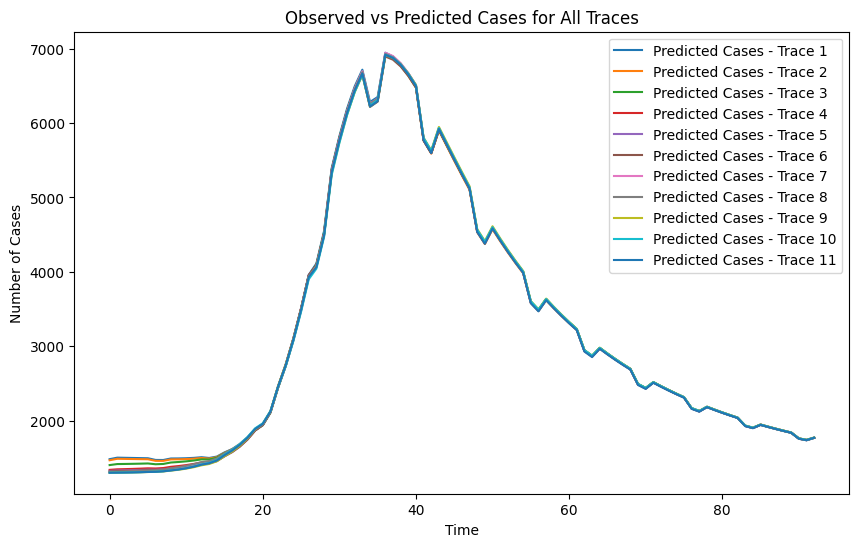

In [ ]:
observed_cases = new_cases_obs

# Annahme: observed_cases und trace_list sind verfügbar
plt.figure(figsize=(10, 6))


# Plot für vorhergesagte Fälle für alle Traces
for i, trace in enumerate(trace_list):
    predicted_cases = trace.posterior["new_cases"].mean(dim=("chain", "draw")).values[:len(new_cases_obs)] + offset
    plt.plot(time_axis, predicted_cases, label=f'Predicted Cases - Trace {i + 1}')

# Legende und Achsentitel
plt.legend()
plt.xlabel('Time')
plt.ylabel('Number of Cases')
plt.title('Observed vs Predicted Cases for All Traces')

# Anzeige des Plots
plt.show()


An dieser Stelle wird nochmal der MSE jeweils berechnet

In [ ]:
# Beobachtete und vorhergesagte Fälle für jeden Trace
observed_cases = new_cases_obs
predicted_cases_traces = {
    "trace1": trace_list[0].posterior["new_cases"].mean(dim=("chain", "draw")).values[:len(new_cases_obs)],
    "trace2": trace_list[1].posterior["new_cases"].mean(dim=("chain", "draw")).values[:len(new_cases_obs)],
    "trace3": trace_list[2].posterior["new_cases"].mean(dim=("chain", "draw")).values[:len(new_cases_obs)],
    "trace4": trace_list[3].posterior["new_cases"].mean(dim=("chain", "draw")).values[:len(new_cases_obs)],
    "trace5": trace_list[4].posterior["new_cases"].mean(dim=("chain", "draw")).values[:len(new_cases_obs)],
    "trace6": trace_list[5].posterior["new_cases"].mean(dim=("chain", "draw")).values[:len(new_cases_obs)],
    "trace7": trace_list[6].posterior["new_cases"].mean(dim=("chain", "draw")).values[:len(new_cases_obs)],
    "trace8": trace_list[7].posterior["new_cases"].mean(dim=("chain", "draw")).values[:len(new_cases_obs)],
    "trace9": trace_list[8].posterior["new_cases"].mean(dim=("chain", "draw")).values[:len(new_cases_obs)],
    "trace10": trace_list[9].posterior["new_cases"].mean(dim=("chain", "draw")).values[:len(new_cases_obs)],
    "trace11": trace_list[10].posterior["new_cases"].mean(dim=("chain", "draw")).values[:len(new_cases_obs)],
}

# Varianz der beobachteten Fälle
variance_observed = observed_cases.var()
print("Varianz der neu beobachteten Fälle:", variance_observed)

# Berechne den Mean Squared Error (MSE) und den Normalized Mean Squared Error (NMSE) für jeden Trace
mse_values = {}
nmse_values = {}

for trace_name, predicted_cases in predicted_cases_traces.items():
    # Berechne die quadratischen Fehler
    squared_errors = (observed_cases - predicted_cases)**2

    # Berechne den Durchschnitt der quadratischen Fehler (MSE)
    mse = squared_errors.mean()
    mse_values[trace_name] = mse

    # Berechne den Normalized Mean Squared Error (NMSE)
    nmse = mse / variance_observed
    nmse_values[trace_name] = nmse

    print(f"Trace {trace_name}:")
    print("Mean Squared Error:", mse)
    print("Normalized Mean Squared Error:", nmse)
    print()

# Rückgabe der berechneten Werte, falls sie weiterverwendet werden sollen
mse_values, nmse_values

Varianz der neu beobachteten Fälle: 3228203.0352968676
Trace trace1:
Mean Squared Error: 4608965.01656765
Normalized Mean Squared Error: 1.4277184446497513

Trace trace2:
Mean Squared Error: 4631897.029888691
Normalized Mean Squared Error: 1.434822091189422

Trace trace3:
Mean Squared Error: 4659662.431133097
Normalized Mean Squared Error: 1.4434229756260022



({'trace1': 4608965.01656765,
  'trace2': 4631897.029888691,
  'trace3': 4659662.431133097},
 {'trace1': 1.4277184446497513,
  'trace2': 1.434822091189422,
  'trace3': 1.4434229756260022})